<a href="https://colab.research.google.com/github/AmelTaouali/Dashboard/blob/main/Analyse_de_la_consommation_mondiale_d%E2%80%99eau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Partie 1 : Manipulation des RDD

In [ ]:
# [Installation et importations]
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from google.colab import drive
import os
import shutil
import statistics

# [Initialisation de Spark]
try:
    sc.stop()
except:
    pass
# Configuration de spark
conf = SparkConf().setAppName("WaterAnalysis").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)


In [ ]:
# [1. Charger le fichier CSV en RDD et supprimer l’en-tête]
file_path = "cleaned_global_water_consumption.csv"

# %% Chargement des données en RDD
raw_rdd = sc.textFile(file_path)  # Charger le fichier CSV en RDD
print(f"\nNombre initial de lignes : {raw_rdd.count()}")

# Suppression de l'en-tête
header = raw_rdd.first() # Récupérer la première ligne (en-tête)
data_rdd = raw_rdd.filter(lambda line: line != header) # Filtrer pour supprimer l'en-tête
print(f"Lignes après suppression de l'en-tête : {data_rdd.count()}") # Afficher le nombre de lignes restantes


Nombre initial de lignes : 501
Lignes après suppression de l'en-tête : 500


In [ ]:
# [2. Transformer les données (split et conversion)]
def parse_line(line):
    parts = line.split(",")
    if len(parts) != 9:
        return None
    try:
        return (
            parts[0].strip(),        # Country
            int(parts[1]),           # Year
            float(parts[2]),         # Total Consumption
            float(parts[3]),         # Per Capita
            float(parts[4]),         # Agricultural %
            float(parts[5]),         # Industrial %
            float(parts[6]),         # Household %
            float(parts[7]),         # Rainfall
            float(parts[8])          # Groundwater Depletion
        )
    except ValueError:
        return None

parsed_rdd = data_rdd.map(parse_line).filter(lambda x: x is not None)
print(f"\nLignes valides après parsing : {parsed_rdd.count()}")
print("\nExemples de données après parsing :")
for row in parsed_rdd.take(5):
    print(row)


Lignes valides après parsing : 500

Exemples de données après parsing :
('Argentina', 2000, 481.49, 235.4314286, 48.55, 20.84428571, 30.1, 1288.698571, 3.255714286)
('Argentina', 2001, 455.063, 299.551, 48.465, 26.943, 22.55, 1371.729, 3.12)
('Argentina', 2002, 482.7492308, 340.1246154, 50.37538462, 29.04230769, 23.34923077, 1590.305385, 2.733846154)
('Argentina', 2003, 452.66, 326.7566667, 49.08666667, 30.476, 24.44, 1816.012667, 2.708)
('Argentina', 2004, 634.566, 230.346, 38.67, 36.67, 23.924, 815.998, 1.902)


In [ ]:
# [3. Application des transformations de base]

# a) map : structurer (Country, Total Consumption)
mapped_rdd = parsed_rdd.map(lambda x: (x[0], x[2]))
print("\nExemples après map (pays, consommation totale) :")
for row in mapped_rdd.take(5):
    print(row)


Exemples après map (pays, consommation totale) :
('Argentina', 481.49)
('Argentina', 455.063)
('Argentina', 482.7492308)
('Argentina', 452.66)
('Argentina', 634.566)


In [ ]:
# b) filter : garder seulement consommation totale > 0
filtered_rdd = mapped_rdd.filter(lambda x: x[1] > 0)
print(f"\nNombre de lignes après filtre (consommation > 0) : {filtered_rdd.count()}")
print("\nExemples après filtre :")
for row in filtered_rdd.take(5):
    print(row)


Nombre de lignes après filtre (consommation > 0) : 500

Exemples après filtre :
('Argentina', 481.49)
('Argentina', 455.063)
('Argentina', 482.7492308)
('Argentina', 452.66)
('Argentina', 634.566)


In [ ]:
# c) reduce : Consommation totale par pays
reduced_rdd = filtered_rdd.reduceByKey(lambda a, b: a + b)
print("\nExemples après reduceByKey (consommation totale par pays) :")
for row in reduced_rdd.take(5):
    print(row)


Exemples après reduceByKey (consommation totale par pays) :
('Australia', 12505.778389299998)
('China', 13133.596733100001)
('France', 12596.115706899996)
('Germany', 12668.5889269)
('Italy', 12449.631513100001)


In [ ]:
# d) sortByKey : Tri alphabétique des pays
sorted_rdd = reduced_rdd.sortByKey()
print("\nExemples après sortByKey (tri alphabétique) :")
for row in sorted_rdd.take(5):
    print(row)


Exemples après sortByKey (tri alphabétique) :
('Argentina', 13284.860759399999)
('Australia', 12505.778389299998)
('Brazil', 13263.2874357)
('Canada', 12352.694690300003)
('China', 13133.596733100001)


In [ ]:
# [EXPLORATIONS SUPPLÉMENTAIRES]

# e) Trier par consommation décroissante (TOP pays consommateurs)
sorted_by_value = reduced_rdd.sortBy(lambda x: -x[1])
print("\nTop 10 des pays consommateurs d'eau :")
for i, (country, total) in enumerate(sorted_by_value.take(10), 1):
    print(f"{i}. {country:<20} : {total:.2f} milliards m³")

# f) Trouver pays avec MIN et MAX consommation
min_country = reduced_rdd.min(key=lambda x: x[1])
max_country = reduced_rdd.max(key=lambda x: x[1])

print(f"\nPays avec la consommation la plus FAIBLE : {min_country[0]} ({min_country[1]:.2f} milliards m³)")
print(f"Pays avec la consommation la plus ÉLEVÉE : {max_country[0]} ({max_country[1]:.2f} milliards m³)")

# g) Calculer moyenne de consommation entre pays
consumption_values = reduced_rdd.map(lambda x: x[1]).collect()
average_consumption = statistics.mean(consumption_values)
print(f"\nConsommation moyenne d'eau par pays : {average_consumption:.2f} milliards m³")

# h) Nombre total de pays étudiés
total_countries = reduced_rdd.count()
print(f"\nNombre total de pays dans les données : {total_countries}")

# i) Rechercher pays spécifiques (exemple : France, USA, India)
specific_countries = ["France", "United States", "India"]
for country in specific_countries:
    search = reduced_rdd.filter(lambda x: x[0] == country).collect()
    if search:
        print(f"{country} : {search[0][1]:.2f} milliards m³")
    else:
        print(f"{country} : Données non trouvées.")

# [Sauvegarde du résultat]
output_rdd_path = "/content/drive/MyDrive/Colab Notebooks/rdd_final_results"
if os.path.exists(output_rdd_path):
    shutil.rmtree(output_rdd_path)

sorted_rdd.saveAsTextFile(output_rdd_path)
print(f"\nRésultats finaux sauvegardés dans : {output_rdd_path}")



Top 10 des pays consommateurs d'eau :
1. Argentina            : 13284.86 milliards m³
2. Brazil               : 13263.29 milliards m³
3. China                : 13133.60 milliards m³
4. USA                  : 13058.95 milliards m³
5. Saudi Arabia         : 12966.08 milliards m³
6. Germany              : 12668.59 milliards m³
7. France               : 12596.12 milliards m³
8. Japan                : 12585.68 milliards m³
9. India                : 12581.66 milliards m³
10. South Africa         : 12544.93 milliards m³

Pays avec la consommation la plus FAIBLE : Spain (11796.58 milliards m³)
Pays avec la consommation la plus ÉLEVÉE : Argentina (13284.86 milliards m³)

Consommation moyenne d'eau par pays : 12530.61 milliards m³

Nombre total de pays dans les données : 20
France : 12596.12 milliards m³
United States : Données non trouvées.
India : 12581.66 milliards m³

Résultats finaux sauvegardés dans : /content/drive/MyDrive/Colab Notebooks/rdd_final_results


Partie 2 : Utilisation de Spark SQL

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

# 4. Recharger et parser les données correctement en DataFrame
schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("TotalConsumption", FloatType(), True),
    StructField("PerCapita", FloatType(), True),
    StructField("AgriculturalPercent", FloatType(), True),
    StructField("IndustrialPercent", FloatType(), True),
    StructField("HouseholdPercent", FloatType(), True),
    StructField("Rainfall", FloatType(), True),
    StructField("GroundwaterDepletion", FloatType(), True)
])

# Parser l'ancien RDD parsed_rdd en DataFrame
df = spark.createDataFrame(parsed_rdd, schema=schema)

# Vérification des données manquantes
df = df.dropna()

# Afficher un aperçu des données
df.show(5)

# Créer une vue temporaire pour utiliser SQL
df.createOrReplaceTempView("water_consumption")

+---------+----+----------------+---------+-------------------+-----------------+----------------+---------+--------------------+
|  Country|Year|TotalConsumption|PerCapita|AgriculturalPercent|IndustrialPercent|HouseholdPercent| Rainfall|GroundwaterDepletion|
+---------+----+----------------+---------+-------------------+-----------------+----------------+---------+--------------------+
|Argentina|2000|          481.49|235.43143|              48.55|        20.844286|            30.1|1288.6986|           3.2557142|
|Argentina|2001|         455.063|  299.551|             48.465|           26.943|           22.55| 1371.729|                3.12|
|Argentina|2002|       482.74924| 340.1246|          50.375385|        29.042307|       23.349232|1590.3054|           2.7338462|
|Argentina|2003|          452.66|326.75665|          49.086666|           30.476|           24.44|1816.0127|               2.708|
|Argentina|2004|         634.566|  230.346|              38.67|            36.67|         

In [ ]:
# 5. Exécuter les requêtes suivantes

# 1. Classer les pays selon la proportion d'utilisation de l’eau en agriculture
query_agriculture = """
SELECT Country, AVG(AgriculturalPercent) as AvgAgricultureUse
FROM water_consumption
GROUP BY Country
ORDER BY AvgAgricultureUse DESC
"""
result_agriculture = spark.sql(query_agriculture)
print("\nPays classés par utilisation de l'eau en agriculture :")
result_agriculture.show(10)


Pays classés par utilisation de l'eau en agriculture :
+------------+------------------+
|     Country| AvgAgricultureUse|
+------------+------------------+
|   Australia| 52.80133102416992|
|      Turkey| 51.84063430786133|
|       China| 51.70537551879883|
|   Argentina| 51.43796859741211|
|South Africa| 50.66973724365234|
|      Russia| 50.53158004760742|
| South Korea|50.477440185546875|
|         USA| 50.45468292236328|
|          UK|50.424591522216794|
|      Canada| 50.32800735473633|
+------------+------------------+
only showing top 10 rows



Les résultats montrent que dans les pays listés, environ 50 % de l’eau est utilisée pour l’agriculture.

L’Australie arrive en tête, probablement à cause de son climat sec nécessitant beaucoup d’irrigation.

Même des pays développés comme le Royaume-Uni, les États-Unis et le Canada ont une part élevée d’utilisation agricole, ce qui montre que l’agriculture reste un secteur très consommateur d’eau, quel que soit le niveau d’industrialisation.



In [ ]:
# 2. Identifier les pays avec l’utilisation industrielle de l’eau la plus élevée
query_industry = """
SELECT Country, AVG(IndustrialPercent) as AvgIndustrialUse
FROM water_consumption
GROUP BY Country
ORDER BY AvgIndustrialUse DESC
"""
result_industry = spark.sql(query_industry)
print("\nPays classés par utilisation de l'eau dans l'industrie :")
result_industry.show(10)


Pays classés par utilisation de l'eau dans l'industrie :
+------------+------------------+
|     Country|  AvgIndustrialUse|
+------------+------------------+
|      Canada|     29.4653515625|
|      Turkey|29.102000732421875|
|       Japan|28.821843643188476|
|   Australia| 28.72440361022949|
|South Africa|28.687092514038085|
|     Germany|28.645994720458983|
|       Italy| 28.07884880065918|
|      Mexico|27.989065017700195|
|   Argentina| 27.94676139831543|
|       India|27.919001083374024|
+------------+------------------+
only showing top 10 rows



Les pays avec la plus forte proportion d’eau utilisée dans l’industrie sont majoritairement des économies industrialisées ou émergentes :

Le Canada se classe premier avec près de 29,5 % de l’eau utilisée à des fins industrielles, ce qui reflète l’importance de ses secteurs manufacturiers et miniers.

La Turquie, le Japon, l’Allemagne et l’Italie figurent également en haut du classement, ce qui est cohérent avec leur forte activité industrielle.

Même des pays comme l’Inde et l’Argentine, souvent perçus comme agricoles, montrent une part significative d’usage industriel.

👉 Cela suggère que l’industrialisation influence fortement la répartition sectorielle de la consommation d’eau, indépendamment du développement global du pays.

In [ ]:
# 3. Analyser la corrélation entre épuisement des eaux souterraines et consommation totale
query_correlation = """
SELECT GroundwaterDepletion, TotalConsumption
FROM water_consumption
WHERE GroundwaterDepletion IS NOT NULL AND TotalConsumption IS NOT NULL
"""
result_correlation = spark.sql(query_correlation)
print("\nRelation entre Groundwater Depletion et Total Consumption :")
result_correlation.show(5)

#(BONUS) Calcul de la corrélation en utilisant Pearson
correlation_data = result_correlation.rdd.map(lambda row: (row['GroundwaterDepletion'], row['TotalConsumption'])).collect()
if correlation_data:
    from scipy.stats import pearsonr
    x, y = zip(*correlation_data)
    correlation, p_value = pearsonr(x, y)
    print(f"\nCoefficient de corrélation (Pearson) : {correlation:.3f}")
else:
    print("\nPas assez de données pour calculer la corrélation.")


Relation entre Groundwater Depletion et Total Consumption :
+--------------------+----------------+
|GroundwaterDepletion|TotalConsumption|
+--------------------+----------------+
|           3.2557142|          481.49|
|                3.12|         455.063|
|           2.7338462|       482.74924|
|               2.708|          452.66|
|               1.902|         634.566|
+--------------------+----------------+
only showing top 5 rows


Coefficient de corrélation (Pearson) : 0.020


Le coefficient de corrélation de 0.020 signifie qu’il n’y a pratiquement aucun lien entre :

la consommation totale d’eau,

et l’épuisement des eaux souterraines.

➡️ En clair : plus un pays consomme d’eau ne veut pas dire qu’il puise plus dans ses nappes souterraines. Cela dépend d’autres facteurs, comme la source de l’eau (pluie, surface, souterraine).

In [ ]:
# 4. Comparer la consommation domestique entre les continents
# Continent mapping
# Full Continent mapping
continent_mapping = {
    "Australia":"Australia",
    "Argentina":"America",
    "Brazil":"America",
    "Canada": "America",
    "China": "Asia",
    "France": "Europe",
    "Germany": "Europe",
    "India": "Asia",
    "Indonesia": "Asia",
    "Italy": "Europe",
    "Japan": "Asia",
    "Mexico": "America",
    "Saudi Arabia": "Asia",
    "South Africa": "Africa",
    "South Korea": "Asia",
    "Spain": "Europe",
    "UK": "Europe",
    "United States": "America"
}

# Créer une fonction UDF pour attribuer un continent à chaque pays
def get_continent(country):
    return continent_mapping.get(country, "Other")

# Enregistrer la fonction UDF dans Spark
spark.udf.register("getContinent", get_continent, StringType())

# Ajouter une colonne "Continent" à partir de la fonction UDF
df_with_continent = df.withColumn("Continent", F.expr("getContinent(Country)"))
df_with_continent.createOrReplaceTempView("water_consumption_continent")

# Consommation domestique moyenne par continent
query_domestic = """
SELECT Continent, AVG(HouseholdPercent) as AvgHouseholdUse
FROM water_consumption_continent
GROUP BY Continent
ORDER BY AvgHouseholdUse DESC
"""
result_domestic = spark.sql(query_domestic)
print("\nConsommation domestique moyenne par continent :")
result_domestic.show()


Consommation domestique moyenne par continent :
+---------+------------------+
|Continent|   AvgHouseholdUse|
+---------+------------------+
|Australia| 25.14050422668457|
|   Europe|24.966480102539062|
|     Asia| 24.78978680928548|
|  America|24.759686088562013|
|    Other| 24.73639310201009|
|   Africa|24.690756378173827|
+---------+------------------+



Peu de différence entre les continents : l’usage domestique reste autour de 25% partout.

L’Australie a la proportion la plus élevée, ce qui peut refléter un mode de vie à forte consommation résidentielle ou une gestion efficace des autres usages.

L’Afrique a la part la plus faible, possiblement en lien avec des infrastructures plus limitées ou une priorité donnée à l’agriculture.

In [ ]:
# 5. Étudier l’évolution de l’impact des précipitations sur la consommation d’eau au fil des années
query_rainfall = """
SELECT Year, AVG(Rainfall) as AvgRainfall
FROM water_consumption
GROUP BY Year
ORDER BY Year
"""
result_rainfall = spark.sql(query_rainfall)
print("\nÉvolution moyenne des précipitations par année :")
result_rainfall.show()




Évolution moyenne des précipitations par année :
+----+------------------+
|Year|       AvgRainfall|
+----+------------------+
|2000|1586.0253540039062|
|2001|1471.3031066894532|
|2002|1674.7094787597657|
|2003|1464.8687225341796|
|2004|1465.7704376220704|
|2005|1560.7391052246094|
|2006|1599.8196044921874|
|2007|1553.6243713378906|
|2008|1436.8942993164062|
|2009|1354.7902252197266|
|2010| 1541.657144165039|
|2011|1544.5694488525392|
|2012| 1583.021630859375|
|2013|1629.0881896972655|
|2014|1682.9233154296876|
|2015|1537.5177062988282|
|2016|   1639.7982421875|
|2017|   1601.3357421875|
|2018| 1489.681884765625|
|2019| 1505.187063598633|
+----+------------------+
only showing top 20 rows



Les précipitations moyennes varient d'une année à l'autre, sans tendance claire à la hausse ou à la baisse. Certaines années sont plus humides (ex. : 2002, 2014), d'autres plus sèches (ex. : 2009). Cette variabilité pourrait influencer la consommation d’eau, notamment pour l’agriculture.

Partie 3 : Visualisation des Résultats

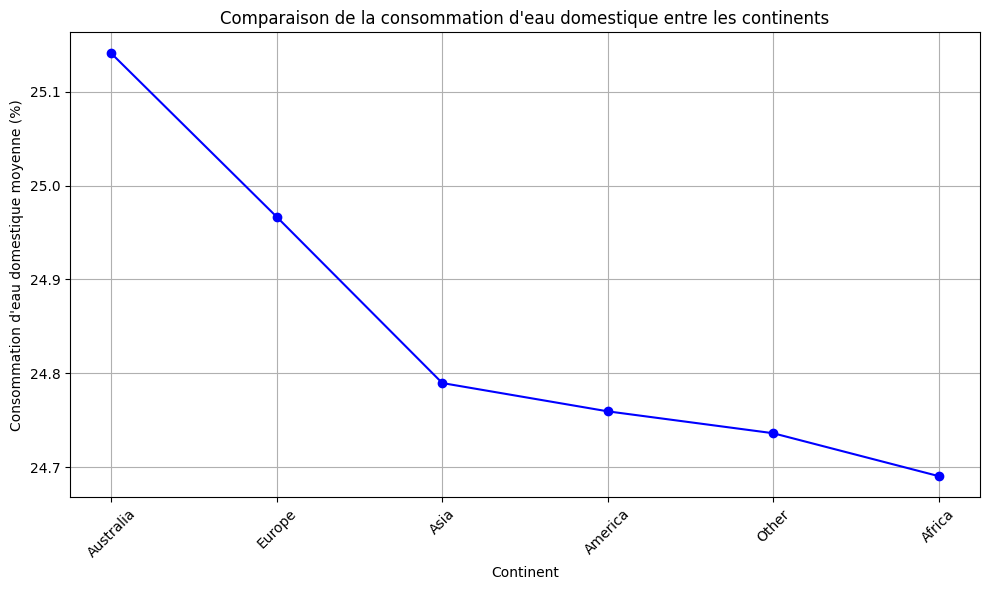

In [ ]:
# %% Convertir les résultats des requêtes SQL en DataFrame Pandas
import matplotlib.pyplot as plt
# 6. Convertir les résultats des requêtes SQL en DataFrame Pandas.
# 7.1. Consommation domestique moyenne par continent (query_domestic)
result_domestic_pandas = result_domestic.toPandas()

# Graphique en ligne comparant la consommation d'eau domestique entre les continents
plt.figure(figsize=(10, 6))
plt.plot(result_domestic_pandas['Continent'], result_domestic_pandas['AvgHouseholdUse'], marker='o', linestyle='-', color='b')
plt.title('Comparaison de la consommation d\'eau domestique entre les continents')
plt.xlabel('Continent')
plt.ylabel('Consommation d\'eau domestique moyenne (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


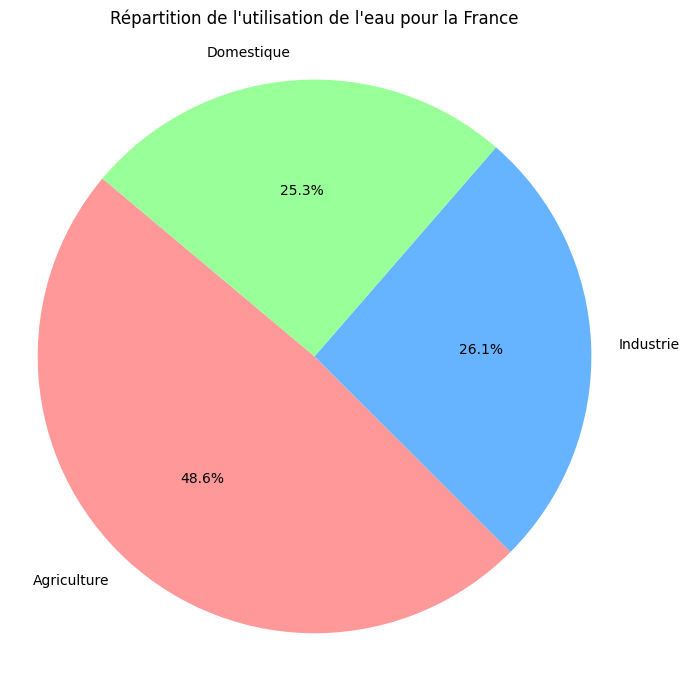

In [ ]:
# 7.2. Répartition de l’utilisation de l’eau pour un pays donné
# Exemple avec le pays "France" (tu peux modifier ce pays)
query_water_distribution = """
SELECT Country, AVG(AgriculturalPercent) as AvgAgricultureUse,
       AVG(IndustrialPercent) as AvgIndustrialUse,
       AVG(HouseholdPercent) as AvgHouseholdUse
FROM water_consumption
WHERE Country = 'France'
GROUP BY Country
"""
result_distribution_pandas = spark.sql(query_water_distribution).toPandas()

# Diagramme en secteurs pour la répartition de l'utilisation de l'eau pour la France
labels = ['Agriculture', 'Industrie', 'Domestique']
sizes = [
    result_distribution_pandas['AvgAgricultureUse'][0],
    result_distribution_pandas['AvgIndustrialUse'][0],
    result_distribution_pandas['AvgHouseholdUse'][0]
]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Répartition de l\'utilisation de l\'eau pour la France')
plt.axis('equal')  # Pour rendre le cercle égal
plt.tight_layout()
plt.show()

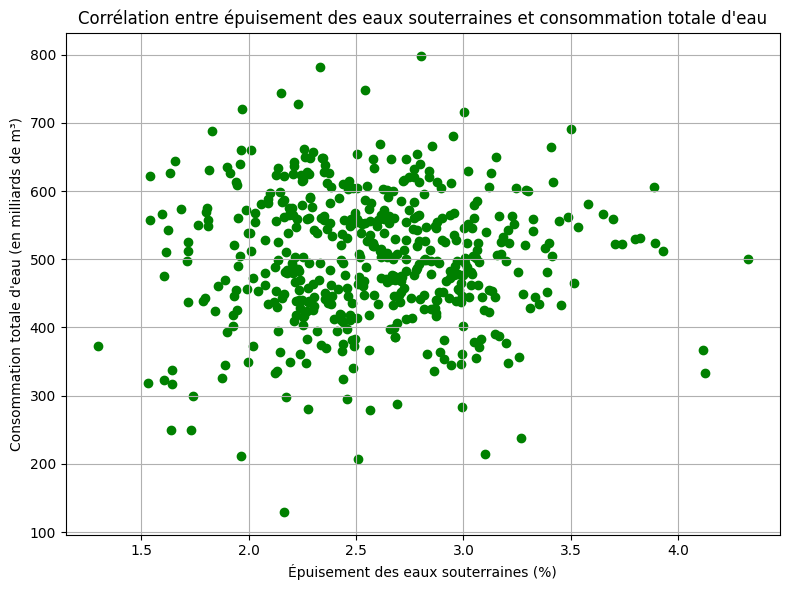

In [ ]:
# 7.3. Relation entre épuisement des eaux souterraines et consommation totale (query_correlation)
result_correlation_pandas = result_correlation.toPandas()

# Corrélation entre l'épuisement des eaux souterraines et la consommation totale d'eau
plt.figure(figsize=(8, 6))
plt.scatter(result_correlation_pandas['GroundwaterDepletion'], result_correlation_pandas['TotalConsumption'], color='g')
plt.title('Corrélation entre épuisement des eaux souterraines et consommation totale d\'eau')
plt.xlabel('Épuisement des eaux souterraines (%)')
plt.ylabel('Consommation totale d\'eau (en milliards de m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


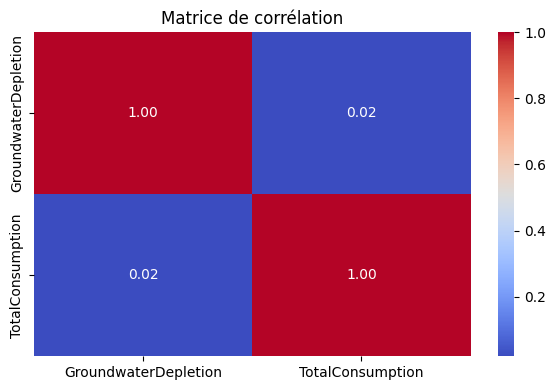

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation avec Pandas
correlation_matrix = result_correlation_pandas.corr(method='pearson')
plt.figure(figsize=(6, 4))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()